In [56]:
# Cell 1: Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import random
import time
import kornia

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()


print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

All libraries imported successfully!
PyTorch version: 2.5.1
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060


In [57]:
# Cell 2: Model Definitions
print("Defining model architectures...")

class Block(nn.Module):
    def __init__(self, in_channels, filter_size, strides, kernel=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, filter_size, kernel, strides, kernel//2),
            nn.BatchNorm2d(filter_size),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.model(x)

class Encoder(nn.Module):    
    def __init__(self, in_channels=2, out_channels=48, constant_feature_map=48):
        super().__init__()
        self.model = nn.Sequential(
            Block(in_channels, constant_feature_map, 1),
            Block(constant_feature_map, constant_feature_map, 2),
            Block(constant_feature_map, constant_feature_map, 1),
            Block(constant_feature_map, constant_feature_map, 2),
            Block(constant_feature_map, out_channels, 1)
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):        
    def __init__(self, in_channels=48, out_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(64, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(16, out_channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, encoder_constant_features=48):
        super().__init__()
        self.encoder = Encoder(in_channels, encoder_constant_features, encoder_constant_features)
        self.decoder = Decoder(encoder_constant_features, out_channels)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        return self.model(x)

print("Model architectures defined successfully!")
print(f"Generator parameters: {sum(p.numel() for p in Generator().parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in Discriminator().parameters()):,}")

Defining model architectures...
Model architectures defined successfully!
Generator parameters: 298,385
Discriminator parameters: 2,756,801


In [58]:
# Cell 3: Dataset Class - UPDATED for CT-MRI dataset structure
print("Defining CT-MRI Dataset class...")

class CTMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None, img_size=(256, 256)):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.img_size = img_size

        # Find all image pairs
        self.image_pairs = []

        print(f"Scanning dataset directory: {root_dir}")

        # Simple structure: root_dir/CT/ and root_dir/MRI/
        ct_dir = self.root_dir / 'CT'
        mri_dir = self.root_dir / 'MRI'

        # Check if both directories exist
        if ct_dir.exists() and mri_dir.exists():
            print("Found CT and MRI directories")

            # Get all PNG files from both directories
            ct_files = sorted(list(ct_dir.glob('*.png')))
            mri_files = sorted(list(mri_dir.glob('*.png')))

            print(f"Found {len(ct_files)} CT images and {len(mri_files)} MRI images")

            # Match files by name (they should have the same names)
            for ct_file in ct_files:
                mri_file = mri_dir / ct_file.name
                if mri_file.exists():
                    self.image_pairs.append((str(ct_file), str(mri_file)))
                else:
                    print(f"Warning: No matching MRI file for {ct_file.name}")

        else:
            print(f"Warning: Missing CT or MRI directory in {root_dir}")
            print(f"Expected: {ct_dir} and {mri_dir}")

        print(f"Found {len(self.image_pairs)} valid image pairs")

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        ct_path, mri_path = self.image_pairs[idx]

        try:
            # Load images
            ct_img = Image.open(ct_path).convert('RGB')
            mri_img = Image.open(mri_path).convert('RGB')

            # Convert to grayscale for fusion
            ct_gray = ct_img.convert('L')
            mri_gray = mri_img.convert('L')

            # Resize images
            ct_gray = ct_gray.resize(self.img_size, Image.Resampling.BILINEAR)
            mri_gray = mri_gray.resize(self.img_size, Image.Resampling.BILINEAR)

            # Convert to tensors and normalize to [-1, 1]
            if self.transform:
                ct_tensor = self.transform(ct_gray)
                mri_tensor = self.transform(mri_gray)
            else:
                ct_tensor = transforms.ToTensor()(ct_gray)
                mri_tensor = transforms.ToTensor()(mri_gray)
                ct_tensor = ct_tensor * 2.0 - 1.0
                mri_tensor = mri_tensor * 2.0 - 1.0

            return ct_tensor, mri_tensor

        except Exception as e:
            print(f"Error loading image pair {ct_path}, {mri_path}: {e}")
            # Return dummy data if there's an error
            dummy_img = torch.rand(1, self.img_size[0], self.img_size[1]) * 2 - 1
            return dummy_img, dummy_img

print("CT-MRI Dataset class defined successfully!")

Defining CT-MRI Dataset class...
CT-MRI Dataset class defined successfully!


In [59]:
# Cell 4: Training Utilities and Trainer Class - UPDATED save_sample_images method
print("Defining training utilities and trainer class...")

def weights_init(m):
    """Initialize network weights"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def gradient_penalty(discriminator, real_samples, fake_samples, device):
    """Calculate gradient penalty for WGAN-GP"""
    batch_size = real_samples.shape[0]
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)
    
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients = gradients.view(gradients.shape[0], -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

class DDcGANTrainer:
    def __init__(self, dataset_path, batch_size=8, lr=0.0002, img_size=(256, 256), device='cuda'):
        self.device = device
        self.batch_size = batch_size
        self.img_size = img_size
        
        print(f"Initializing trainer with batch_size={batch_size}, lr={lr}, img_size={img_size}")
        
        # Data preparation
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
        ])
        
        print("Loading dataset...")
        self.dataset = CTMRIDataset(dataset_path, transform=transform, img_size=img_size)
        self.dataloader = DataLoader(
            self.dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=4,
            pin_memory=True
        )
        
        print("Initializing models...")
        # Initialize models
        self.generator = Generator(in_channels=2, out_channels=1).to(device)
        self.discriminator1 = Discriminator(in_channels=1).to(device)  # Global discriminator
        self.discriminator2 = Discriminator(in_channels=1).to(device)  # Local discriminator
        
        # Apply weight initialization
        self.generator.apply(weights_init)
        self.discriminator1.apply(weights_init)
        self.discriminator2.apply(weights_init)
        
        print("Initializing optimizers...")
        # Optimizers
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        self.d1_optimizer = optim.Adam(self.discriminator1.parameters(), lr=lr, betas=(0.5, 0.999))
        self.d2_optimizer = optim.Adam(self.discriminator2.parameters(), lr=lr, betas=(0.5, 0.999))
        
        # Loss functions
        self.adversarial_loss = nn.MSELoss()
        self.reconstruction_loss = nn.L1Loss()
        
        # Loss weights
        self.lambda_recon = 100.0
        self.lambda_gp = 10.0
        
        # Training history
        self.g_losses = []
        self.d_losses = []
        self.recon_losses = []
        self.g_adv_losses = []
        self.d1_losses = []
        self.d2_losses = []
        self.epoch_times = []
        
        print("Trainer initialized successfully!")
        
    def gradient_loss(self, gen_img, ir_img):
        """Force generator to keep IR edges"""
        gen_grad = kornia.filters.sobel(gen_img)
        ir_grad = kornia.filters.sobel(ir_img)
        return torch.nn.functional.l1_loss(gen_grad, ir_grad)

    def ssim_loss(self, img1, img2):
        """SSIM-based similarity loss"""
        ssim_fn = kornia.losses.SSIMLoss(window_size=11, reduction='mean')
        return ssim_fn(img1, img2)
        
    def train_epoch(self, epoch):
        start_time = time.time()
        self.generator.train()
        self.discriminator1.train()
        self.discriminator2.train()
        
        epoch_g_loss = 0
        epoch_d_loss = 0
        epoch_recon_loss = 0
        epoch_g_adv_loss = 0
        epoch_d1_loss = 0
        epoch_d2_loss = 0
        epoch_ir_loss = 0
        epoch_ssim_loss = 0

        
        pbar = tqdm(self.dataloader, desc=f'Epoch {epoch}')
        
        for i, (ct_imgs, mri_imgs) in enumerate(pbar):
            batch_size = ct_imgs.size(0)
            ct_imgs = ct_imgs.to(self.device)
            mri_imgs = mri_imgs.to(self.device)
            
            # Concatenate CT and MRI images as input
            input_imgs = torch.cat([ct_imgs, mri_imgs], dim=1)
            
            # Real and fake labels
            real_label = torch.ones(batch_size, 1).to(self.device)
            fake_label = torch.zeros(batch_size, 1).to(self.device)
            
            # ---------------------
            # Train Discriminators
            # ---------------------
            
            # Generate fake fused images
            with torch.no_grad():
                fake_fused = self.generator(input_imgs)
            
            # Create "real" fused images (using CT as reference for now)
            real_fused = ct_imgs
            
            # Train Discriminator 1 (Global)
            self.d1_optimizer.zero_grad()
            
            real_pred1 = self.discriminator1(real_fused)
            fake_pred1 = self.discriminator1(fake_fused.detach())
            
            d1_real_loss = self.adversarial_loss(real_pred1, real_label)
            d1_fake_loss = self.adversarial_loss(fake_pred1, fake_label)
            d1_loss = (d1_real_loss + d1_fake_loss) / 2
            
            d1_loss.backward()
            self.d1_optimizer.step()
            
            # Train Discriminator 2 (Local/Detail)
            self.d2_optimizer.zero_grad()
            
            real_pred2 = self.discriminator2(real_fused)
            fake_pred2 = self.discriminator2(fake_fused.detach())
            
            d2_real_loss = self.adversarial_loss(real_pred2, real_label)
            d2_fake_loss = self.adversarial_loss(fake_pred2, fake_label)
            d2_loss = (d2_real_loss + d2_fake_loss) / 2
            
            d2_loss.backward()
            self.d2_optimizer.step()
            
            total_d_loss = d1_loss + d2_loss
            
            # -----------------
            # Train Generator
            # -----------------
            
            self.g_optimizer.zero_grad()
            
            # Generate fused images
            fused_imgs = self.generator(input_imgs)
            
            # Adversarial losses
            pred1 = self.discriminator1(fused_imgs)
            pred2 = self.discriminator2(fused_imgs)
            
            g_adv_loss1 = self.adversarial_loss(pred1, real_label)
            g_adv_loss2 = self.adversarial_loss(pred2, real_label)
            g_adv_loss = (g_adv_loss1 + g_adv_loss2) / 2
            
            # Reconstruction loss (preserve CT + MRI equally)
            g_recon_loss = self.reconstruction_loss(fused_imgs, ct_imgs) + \
                           self.reconstruction_loss(fused_imgs, mri_imgs)
            
            # MRI gradient-preserving loss
            g_ir_loss = self.gradient_loss(fused_imgs, mri_imgs)
            
            # SSIM loss (structural preservation)
            g_ssim_loss = self.ssim_loss(fused_imgs, ct_imgs) + \
                          self.ssim_loss(fused_imgs, mri_imgs)
            
            # Total generator loss with weights
            g_loss = g_adv_loss + \
                     10.0 * g_recon_loss + \
                     5.0 * g_ir_loss + \
                     1.0 * g_ssim_loss

            
            g_loss.backward()
            self.g_optimizer.step()
            
            # Update losses
            epoch_g_loss += g_loss.item()
            epoch_d_loss += total_d_loss.item()
            epoch_recon_loss += g_recon_loss.item()
            epoch_g_adv_loss += g_adv_loss.item()
            epoch_ir_loss += g_ir_loss.item()
            epoch_ssim_loss += g_ssim_loss.item()
            epoch_d1_loss += d1_loss.item()
            epoch_d2_loss += d2_loss.item()
            
            # Update progress bar
            pbar.set_postfix({
                'G_Loss': f'{g_loss.item():.4f}',
                'D_Loss': f'{total_d_loss.item():.4f}',
                'Recon_Loss': f'{g_recon_loss.item():.4f}',
                'G_Adv_Loss': f'{g_adv_loss.item():.4f}',
                'D1_Loss': f'{d1_loss.item():.4f}',
                'D2_Loss': f'{d2_loss.item():.4f}'
            })
            
            # Save sample images every 100 batches
            if i % 100 == 0:
                self.save_sample_images(ct_imgs, mri_imgs, fused_imgs, epoch, i)
        
        # Calculate epoch averages
        avg_g_loss = epoch_g_loss / len(self.dataloader)
        avg_d_loss = epoch_d_loss / len(self.dataloader)
        avg_recon_loss = epoch_recon_loss / len(self.dataloader)
        avg_g_adv_loss = epoch_g_adv_loss / len(self.dataloader)
        avg_ir_loss = epoch_ir_loss / len(self.dataloader)
        avg_ssim_loss = epoch_ssim_loss / len(self.dataloader)
        avg_d1_loss = epoch_d1_loss / len(self.dataloader)
        avg_d2_loss = epoch_d2_loss / len(self.dataloader)
        epoch_time = time.time() - start_time
        
        # Store metrics
        self.g_losses.append(avg_g_loss)
        self.d_losses.append(avg_d_loss)
        self.recon_losses.append(avg_recon_loss)
        self.g_adv_losses.append(avg_g_adv_loss)
        self.d1_losses.append(avg_d1_loss)
        self.d2_losses.append(avg_d2_loss)
        self.epoch_times.append(epoch_time)
        
        # Print epoch summary
        print(f"\nEpoch {epoch} Summary:")
        print(f"  Generator Loss: {avg_g_loss:.4f}")
        print(f"  Discriminator Loss: {avg_d_loss:.4f}")
        print(f"  Reconstruction Loss: {avg_recon_loss:.4f}")
        print(f"  Generator Adversarial Loss: {avg_g_adv_loss:.4f}")
        print(f"  Discriminator 1 Loss: {avg_d1_loss:.4f}")
        print(f"  Discriminator 2 Loss: {avg_d2_loss:.4f}")
        print(f"  Epoch Time: {epoch_time:.2f} seconds")
        print(f"  MRI Loss: {avg_ir_loss:.4f}")
        print(f"  SSIM Loss: {avg_ssim_loss:.4f}")

        
        return avg_g_loss, avg_d_loss
    
    def save_sample_images(self, ct_imgs, mri_imgs, fused_imgs, epoch, batch_idx):
        """Save sample images during training"""
        os.makedirs('samples', exist_ok=True)
        
        # Take first image from batch
        ct_sample = ct_imgs[0].cpu()
        mri_sample = mri_imgs[0].cpu()
        fused_sample = fused_imgs[0].cpu()
        
        # Denormalize images and convert to numpy
        ct_sample = (ct_sample + 1) / 2
        mri_sample = (mri_sample + 1) / 2
        fused_sample = (fused_sample + 1) / 2
        
        # Convert to numpy arrays and ensure proper shape
        ct_np = ct_sample.squeeze().detach().cpu().numpy()
        mri_np = mri_sample.squeeze().detach().cpu().numpy()
        fused_np = fused_sample.squeeze().detach().cpu().numpy()
        
        # Ensure 2D arrays for grayscale
        if len(ct_np.shape) == 3 and ct_np.shape[0] == 1:
            ct_np = ct_np[0]
        if len(mri_np.shape) == 3 and mri_np.shape[0] == 1:
            mri_np = mri_np[0]
        if len(fused_np.shape) == 3 and fused_np.shape[0] == 1:
            fused_np = fused_np[0]
        
        # Create comparison plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(ct_np, cmap='gray')
        axes[0].set_title('CT')
        axes[0].axis('off')
        
        axes[1].imshow(mri_np, cmap='gray')
        axes[1].set_title('MRI')
        axes[1].axis('off')
        
        axes[2].imshow(fused_np, cmap='gray')
        axes[2].set_title('Fused')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'samples/epoch_{epoch}_batch_{batch_idx}.png', dpi=150, bbox_inches='tight')
        plt.close()
    
    def save_model(self, epoch, path='checkpoints'):
        """Save model checkpoints"""
        os.makedirs(path, exist_ok=True)
        
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator1_state_dict': self.discriminator1.state_dict(),
            'discriminator2_state_dict': self.discriminator2.state_dict(),
            'g_optimizer_state_dict': self.g_optimizer.state_dict(),
            'd1_optimizer_state_dict': self.d1_optimizer.state_dict(),
            'd2_optimizer_state_dict': self.d2_optimizer.state_dict(),
            'g_losses': self.g_losses,
            'd_losses': self.d_losses,
            'recon_losses': self.recon_losses,
            'g_adv_losses': self.g_adv_losses,
            'd1_losses': self.d1_losses,
            'd2_losses': self.d2_losses,
            'epoch_times': self.epoch_times
        }
        
        torch.save(checkpoint, f'{path}/ddcgan_epoch_{epoch}.pth')
        print(f'Model saved at epoch {epoch}')
    
    def load_model(self, checkpoint_path):
        """Load model checkpoint"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator1.load_state_dict(checkpoint['discriminator1_state_dict'])
        self.discriminator2.load_state_dict(checkpoint['discriminator2_state_dict'])
        
        self.g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        self.d1_optimizer.load_state_dict(checkpoint['d1_optimizer_state_dict'])
        self.d2_optimizer.load_state_dict(checkpoint['d2_optimizer_state_dict'])
        
        self.g_losses = checkpoint['g_losses']
        self.d_losses = checkpoint['d_losses']
        self.recon_losses = checkpoint['recon_losses']
        self.g_adv_losses = checkpoint['g_adv_losses']
        self.d1_losses = checkpoint['d1_losses']
        self.d2_losses = checkpoint['d2_losses']
        self.epoch_times = checkpoint['epoch_times']
        
        return checkpoint['epoch']
    
    def train(self, num_epochs, save_interval=5):
        """Main training loop"""
        print(f"Starting training for {num_epochs} epochs...")
        print(f"Dataset size: {len(self.dataset)} image pairs")
        print(f"Batch size: {self.batch_size}")
        print(f"Device: {self.device}")
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            g_loss, d_loss = self.train_epoch(epoch + 1)
            
            print(f'Epoch [{epoch+1}/{num_epochs}] - G_Loss: {g_loss:.4f}, D_Loss: {d_loss:.4f}')
            
            # Save model checkpoint
            if (epoch + 1) % save_interval == 0:
                self.save_model(epoch + 1)
        
        total_time = time.time() - start_time
        print(f"Training completed in {total_time:.2f} seconds!")
        
        # Plot training losses
        self.plot_training_metrics()
    
    def plot_training_metrics(self):
        """Plot all training metrics"""
        os.makedirs('plots', exist_ok=True)
        
        epochs = range(1, len(self.g_losses) + 1)
        
        # Plot 1: Generator and Discriminator losses
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.g_losses, label='Generator Loss')
        plt.plot(epochs, self.d_losses, label='Discriminator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Generator vs Discriminator Loss')
        
        # Plot 2: Component losses
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.recon_losses, label='Reconstruction Loss')
        plt.plot(epochs, self.g_adv_losses, label='Generator Adv Loss')
        plt.plot(epochs, self.d1_losses, label='Discriminator 1 Loss')
        plt.plot(epochs, self.d2_losses, label='Discriminator 2 Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Component Losses')
        
        plt.tight_layout()
        plt.savefig('plots/training_losses.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Plot 3: Epoch times
        plt.figure(figsize=(8, 4))
        plt.plot(epochs, self.epoch_times)
        plt.xlabel('Epoch')
        plt.ylabel('Time (seconds)')
        plt.title('Epoch Training Time')
        plt.savefig('plots/epoch_times.png', dpi=150, bbox_inches='tight')
        plt.show()

print("Training utilities and trainer class defined successfully!")

Defining training utilities and trainer class...
Training utilities and trainer class defined successfully!


In [60]:
# Cell 5: Dataset Preparation and Setup - UPDATED configuration
print("Setting up dataset and training configuration...")

# Configuration - Updated for CT-MRI dataset
BATCH_SIZE = 16  # Increased since we have more data
LEARNING_RATE = 0.0002
NUM_EPOCHS = 30  
IMG_SIZE = (256, 256)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATASET_PATH = "Dataset/CT-MRI"

print(f"Using device: {DEVICE}")
print(f"Dataset path: {DATASET_PATH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Image size: {IMG_SIZE}")

Setting up dataset and training configuration...
Using device: cuda
Dataset path: Dataset/CT-MRI
Batch size: 16
Learning rate: 0.0002
Number of epochs: 30
Image size: (256, 256)


Starting model training...
Initializing trainer with batch_size=16, lr=0.0002, img_size=(256, 256)
Loading dataset...
Scanning dataset directory: Dataset/CT-MRI
Found CT and MRI directories
Found 573 CT images and 573 MRI images
Found 573 valid image pairs
Initializing models...
Initializing optimizers...
Trainer initialized successfully!
Trainer created successfully. Starting training...
Starting training for 30 epochs...
Dataset size: 573 image pairs
Batch size: 16
Device: cuda


Epoch 1: 100%|██████████| 36/36 [00:11<00:00,  3.06it/s, G_Loss=8.7035, D_Loss=0.0759, Recon_Loss=0.7091, G_Adv_Loss=0.7809, D1_Loss=0.0405, D2_Loss=0.0354]



Epoch 1 Summary:
  Generator Loss: 11.3874
  Discriminator Loss: 0.2414
  Reconstruction Loss: 0.9705
  Generator Adversarial Loss: 0.7127
  Discriminator 1 Loss: 0.1456
  Discriminator 2 Loss: 0.0958
  Epoch Time: 11.78 seconds
  MRI Loss: 0.0452
  SSIM Loss: 0.7444
Epoch [1/30] - G_Loss: 11.3874, D_Loss: 0.2414


Epoch 2: 100%|██████████| 36/36 [00:12<00:00,  2.97it/s, G_Loss=6.3857, D_Loss=0.5246, Recon_Loss=0.5348, G_Adv_Loss=0.2958, D1_Loss=0.1934, D2_Loss=0.3311]



Epoch 2 Summary:
  Generator Loss: 7.6670
  Discriminator Loss: 0.1658
  Reconstruction Loss: 0.6171
  Generator Adversarial Loss: 0.7138
  Discriminator 1 Loss: 0.1055
  Discriminator 2 Loss: 0.0603
  Epoch Time: 12.13 seconds
  MRI Loss: 0.0472
  SSIM Loss: 0.5464
Epoch [2/30] - G_Loss: 7.6670, D_Loss: 0.1658


Epoch 3: 100%|██████████| 36/36 [00:12<00:00,  2.96it/s, G_Loss=5.4684, D_Loss=0.4305, Recon_Loss=0.4439, G_Adv_Loss=0.3462, D1_Loss=0.2529, D2_Loss=0.1776]



Epoch 3 Summary:
  Generator Loss: 6.2446
  Discriminator Loss: 0.3092
  Reconstruction Loss: 0.5016
  Generator Adversarial Loss: 0.4906
  Discriminator 1 Loss: 0.1140
  Discriminator 2 Loss: 0.1952
  Epoch Time: 12.15 seconds
  MRI Loss: 0.0489
  SSIM Loss: 0.4929
Epoch [3/30] - G_Loss: 6.2446, D_Loss: 0.3092


Epoch 4: 100%|██████████| 36/36 [00:12<00:00,  2.98it/s, G_Loss=5.9147, D_Loss=0.5776, Recon_Loss=0.4367, G_Adv_Loss=0.8752, D1_Loss=0.2383, D2_Loss=0.3393]



Epoch 4 Summary:
  Generator Loss: 5.7703
  Discriminator Loss: 0.3071
  Reconstruction Loss: 0.4545
  Generator Adversarial Loss: 0.5019
  Discriminator 1 Loss: 0.1362
  Discriminator 2 Loss: 0.1710
  Epoch Time: 12.09 seconds
  MRI Loss: 0.0522
  SSIM Loss: 0.4621
Epoch [4/30] - G_Loss: 5.7703, D_Loss: 0.3071


Epoch 5: 100%|██████████| 36/36 [00:12<00:00,  2.97it/s, G_Loss=5.4785, D_Loss=0.1834, Recon_Loss=0.4181, G_Adv_Loss=0.6212, D1_Loss=0.0894, D2_Loss=0.0939]



Epoch 5 Summary:
  Generator Loss: 5.4066
  Discriminator Loss: 0.3589
  Reconstruction Loss: 0.4278
  Generator Adversarial Loss: 0.4214
  Discriminator 1 Loss: 0.1723
  Discriminator 2 Loss: 0.1866
  Epoch Time: 12.11 seconds
  MRI Loss: 0.0528
  SSIM Loss: 0.4434
Epoch [5/30] - G_Loss: 5.4066, D_Loss: 0.3589


Epoch 6: 100%|██████████| 36/36 [00:12<00:00,  2.97it/s, G_Loss=5.1930, D_Loss=0.3863, Recon_Loss=0.4082, G_Adv_Loss=0.4039, D1_Loss=0.1960, D2_Loss=0.1903]



Epoch 6 Summary:
  Generator Loss: 5.3049
  Discriminator Loss: 0.3837
  Reconstruction Loss: 0.4183
  Generator Adversarial Loss: 0.4121
  Discriminator 1 Loss: 0.1820
  Discriminator 2 Loss: 0.2017
  Epoch Time: 12.10 seconds
  MRI Loss: 0.0536
  SSIM Loss: 0.4422
Epoch [6/30] - G_Loss: 5.3049, D_Loss: 0.3837


Epoch 7: 100%|██████████| 36/36 [00:12<00:00,  2.98it/s, G_Loss=4.9786, D_Loss=0.4174, Recon_Loss=0.3850, G_Adv_Loss=0.4484, D1_Loss=0.2373, D2_Loss=0.1801]



Epoch 7 Summary:
  Generator Loss: 5.2165
  Discriminator Loss: 0.3718
  Reconstruction Loss: 0.4101
  Generator Adversarial Loss: 0.4075
  Discriminator 1 Loss: 0.1788
  Discriminator 2 Loss: 0.1929
  Epoch Time: 12.10 seconds
  MRI Loss: 0.0545
  SSIM Loss: 0.4353
Epoch [7/30] - G_Loss: 5.2165, D_Loss: 0.3718


Epoch 8: 100%|██████████| 36/36 [00:12<00:00,  2.98it/s, G_Loss=5.1001, D_Loss=0.3813, Recon_Loss=0.4158, G_Adv_Loss=0.3024, D1_Loss=0.1919, D2_Loss=0.1893]



Epoch 8 Summary:
  Generator Loss: 5.1420
  Discriminator Loss: 0.4005
  Reconstruction Loss: 0.4056
  Generator Adversarial Loss: 0.3871
  Discriminator 1 Loss: 0.2025
  Discriminator 2 Loss: 0.1980
  Epoch Time: 12.09 seconds
  MRI Loss: 0.0533
  SSIM Loss: 0.4327
Epoch [8/30] - G_Loss: 5.1420, D_Loss: 0.4005


Epoch 9: 100%|██████████| 36/36 [00:12<00:00,  2.93it/s, G_Loss=5.3160, D_Loss=0.3886, Recon_Loss=0.4204, G_Adv_Loss=0.4242, D1_Loss=0.2157, D2_Loss=0.1729]



Epoch 9 Summary:
  Generator Loss: 5.1415
  Discriminator Loss: 0.3978
  Reconstruction Loss: 0.4056
  Generator Adversarial Loss: 0.3839
  Discriminator 1 Loss: 0.2028
  Discriminator 2 Loss: 0.1950
  Epoch Time: 12.28 seconds
  MRI Loss: 0.0533
  SSIM Loss: 0.4345
Epoch [9/30] - G_Loss: 5.1415, D_Loss: 0.3978


Epoch 10: 100%|██████████| 36/36 [00:12<00:00,  2.97it/s, G_Loss=5.1069, D_Loss=0.4025, Recon_Loss=0.4093, G_Adv_Loss=0.2566, D1_Loss=0.2102, D2_Loss=0.1923]




Epoch 10 Summary:
  Generator Loss: 5.0559
  Discriminator Loss: 0.4080
  Reconstruction Loss: 0.3997
  Generator Adversarial Loss: 0.3681
  Discriminator 1 Loss: 0.2035
  Discriminator 2 Loss: 0.2045
  Epoch Time: 12.11 seconds
  MRI Loss: 0.0527
  SSIM Loss: 0.4272
Epoch [10/30] - G_Loss: 5.0559, D_Loss: 0.4080
Model saved at epoch 10
Model saved at epoch 10


Epoch 11: 100%|██████████| 36/36 [00:11<00:00,  3.01it/s, G_Loss=4.6474, D_Loss=0.4910, Recon_Loss=0.3683, G_Adv_Loss=0.2495, D1_Loss=0.2671, D2_Loss=0.2239]



Epoch 11 Summary:
  Generator Loss: 5.0498
  Discriminator Loss: 0.4078
  Reconstruction Loss: 0.3996
  Generator Adversarial Loss: 0.3600
  Discriminator 1 Loss: 0.2063
  Discriminator 2 Loss: 0.2016
  Epoch Time: 11.96 seconds
  MRI Loss: 0.0538
  SSIM Loss: 0.4253
Epoch [11/30] - G_Loss: 5.0498, D_Loss: 0.4078


Epoch 12: 100%|██████████| 36/36 [00:12<00:00,  2.95it/s, G_Loss=4.8507, D_Loss=0.4120, Recon_Loss=0.3759, G_Adv_Loss=0.4356, D1_Loss=0.1849, D2_Loss=0.2272]



Epoch 12 Summary:
  Generator Loss: 5.0358
  Discriminator Loss: 0.4111
  Reconstruction Loss: 0.3984
  Generator Adversarial Loss: 0.3562
  Discriminator 1 Loss: 0.2061
  Discriminator 2 Loss: 0.2050
  Epoch Time: 12.21 seconds
  MRI Loss: 0.0540
  SSIM Loss: 0.4250
Epoch [12/30] - G_Loss: 5.0358, D_Loss: 0.4111


Epoch 13: 100%|██████████| 36/36 [00:12<00:00,  2.96it/s, G_Loss=5.1920, D_Loss=0.4929, Recon_Loss=0.4037, G_Adv_Loss=0.4445, D1_Loss=0.2499, D2_Loss=0.2430]



Epoch 13 Summary:
  Generator Loss: 4.9841
  Discriminator Loss: 0.4128
  Reconstruction Loss: 0.3955
  Generator Adversarial Loss: 0.3437
  Discriminator 1 Loss: 0.2071
  Discriminator 2 Loss: 0.2056
  Epoch Time: 12.18 seconds
  MRI Loss: 0.0539
  SSIM Loss: 0.4155
Epoch [13/30] - G_Loss: 4.9841, D_Loss: 0.4128


Epoch 14: 100%|██████████| 36/36 [00:12<00:00,  2.98it/s, G_Loss=4.8199, D_Loss=0.5627, Recon_Loss=0.3689, G_Adv_Loss=0.4753, D1_Loss=0.2876, D2_Loss=0.2751]



Epoch 14 Summary:
  Generator Loss: 4.9789
  Discriminator Loss: 0.4348
  Reconstruction Loss: 0.3953
  Generator Adversarial Loss: 0.3403
  Discriminator 1 Loss: 0.2243
  Discriminator 2 Loss: 0.2104
  Epoch Time: 12.09 seconds
  MRI Loss: 0.0539
  SSIM Loss: 0.4161
Epoch [14/30] - G_Loss: 4.9789, D_Loss: 0.4348


Epoch 15: 100%|██████████| 36/36 [00:12<00:00,  2.97it/s, G_Loss=4.8263, D_Loss=0.4237, Recon_Loss=0.3771, G_Adv_Loss=0.3776, D1_Loss=0.2227, D2_Loss=0.2009]



Epoch 15 Summary:
  Generator Loss: 4.9995
  Discriminator Loss: 0.4160
  Reconstruction Loss: 0.3961
  Generator Adversarial Loss: 0.3367
  Discriminator 1 Loss: 0.2077
  Discriminator 2 Loss: 0.2083
  Epoch Time: 12.11 seconds
  MRI Loss: 0.0572
  SSIM Loss: 0.4160
Epoch [15/30] - G_Loss: 4.9995, D_Loss: 0.4160


Epoch 16: 100%|██████████| 36/36 [00:12<00:00,  2.98it/s, G_Loss=5.4215, D_Loss=0.4628, Recon_Loss=0.4405, G_Adv_Loss=0.2385, D1_Loss=0.2383, D2_Loss=0.2245]



Epoch 16 Summary:
  Generator Loss: 4.9791
  Discriminator Loss: 0.4406
  Reconstruction Loss: 0.3944
  Generator Adversarial Loss: 0.3405
  Discriminator 1 Loss: 0.2223
  Discriminator 2 Loss: 0.2183
  Epoch Time: 12.08 seconds
  MRI Loss: 0.0565
  SSIM Loss: 0.4119
Epoch [16/30] - G_Loss: 4.9791, D_Loss: 0.4406


Epoch 17: 100%|██████████| 36/36 [00:12<00:00,  2.95it/s, G_Loss=4.7852, D_Loss=0.4447, Recon_Loss=0.3858, G_Adv_Loss=0.2335, D1_Loss=0.2298, D2_Loss=0.2149]



Epoch 17 Summary:
  Generator Loss: 4.9512
  Discriminator Loss: 0.4229
  Reconstruction Loss: 0.3930
  Generator Adversarial Loss: 0.3314
  Discriminator 1 Loss: 0.2154
  Discriminator 2 Loss: 0.2075
  Epoch Time: 12.21 seconds
  MRI Loss: 0.0559
  SSIM Loss: 0.4103
Epoch [17/30] - G_Loss: 4.9512, D_Loss: 0.4229


Epoch 18: 100%|██████████| 36/36 [00:12<00:00,  3.00it/s, G_Loss=5.8931, D_Loss=0.3808, Recon_Loss=0.4686, G_Adv_Loss=0.4073, D1_Loss=0.1971, D2_Loss=0.1837]



Epoch 18 Summary:
  Generator Loss: 4.9851
  Discriminator Loss: 0.4303
  Reconstruction Loss: 0.3955
  Generator Adversarial Loss: 0.3294
  Discriminator 1 Loss: 0.2148
  Discriminator 2 Loss: 0.2155
  Epoch Time: 12.01 seconds
  MRI Loss: 0.0580
  SSIM Loss: 0.4107
Epoch [18/30] - G_Loss: 4.9851, D_Loss: 0.4303


Epoch 19: 100%|██████████| 36/36 [00:11<00:00,  3.01it/s, G_Loss=4.9485, D_Loss=0.4317, Recon_Loss=0.3954, G_Adv_Loss=0.2674, D1_Loss=0.2183, D2_Loss=0.2134]



Epoch 19 Summary:
  Generator Loss: 4.9815
  Discriminator Loss: 0.4324
  Reconstruction Loss: 0.3953
  Generator Adversarial Loss: 0.3297
  Discriminator 1 Loss: 0.2201
  Discriminator 2 Loss: 0.2124
  Epoch Time: 11.98 seconds
  MRI Loss: 0.0580
  SSIM Loss: 0.4086
Epoch [19/30] - G_Loss: 4.9815, D_Loss: 0.4324


Epoch 20: 100%|██████████| 36/36 [00:11<00:00,  3.02it/s, G_Loss=4.8825, D_Loss=0.4579, Recon_Loss=0.3908, G_Adv_Loss=0.2473, D1_Loss=0.2223, D2_Loss=0.2357]




Epoch 20 Summary:
  Generator Loss: 4.9462
  Discriminator Loss: 0.4366
  Reconstruction Loss: 0.3929
  Generator Adversarial Loss: 0.3175
  Discriminator 1 Loss: 0.2178
  Discriminator 2 Loss: 0.2187
  Epoch Time: 11.93 seconds
  MRI Loss: 0.0595
  SSIM Loss: 0.4025
Epoch [20/30] - G_Loss: 4.9462, D_Loss: 0.4366
Model saved at epoch 20
Model saved at epoch 20


Epoch 21: 100%|██████████| 36/36 [00:12<00:00,  2.99it/s, G_Loss=4.7307, D_Loss=0.4206, Recon_Loss=0.3707, G_Adv_Loss=0.3563, D1_Loss=0.2228, D2_Loss=0.1978]



Epoch 21 Summary:
  Generator Loss: 4.9608
  Discriminator Loss: 0.4323
  Reconstruction Loss: 0.3936
  Generator Adversarial Loss: 0.3297
  Discriminator 1 Loss: 0.2126
  Discriminator 2 Loss: 0.2197
  Epoch Time: 12.02 seconds
  MRI Loss: 0.0584
  SSIM Loss: 0.4036
Epoch [21/30] - G_Loss: 4.9608, D_Loss: 0.4323


Epoch 22: 100%|██████████| 36/36 [00:11<00:00,  3.01it/s, G_Loss=5.3249, D_Loss=0.3790, Recon_Loss=0.4227, G_Adv_Loss=0.3614, D1_Loss=0.1948, D2_Loss=0.1842]



Epoch 22 Summary:
  Generator Loss: 4.9572
  Discriminator Loss: 0.4313
  Reconstruction Loss: 0.3929
  Generator Adversarial Loss: 0.3301
  Discriminator 1 Loss: 0.2149
  Discriminator 2 Loss: 0.2164
  Epoch Time: 11.96 seconds
  MRI Loss: 0.0580
  SSIM Loss: 0.4075
Epoch [22/30] - G_Loss: 4.9572, D_Loss: 0.4313


Epoch 23: 100%|██████████| 36/36 [00:12<00:00,  2.96it/s, G_Loss=5.1359, D_Loss=0.5826, Recon_Loss=0.4011, G_Adv_Loss=0.4661, D1_Loss=0.3002, D2_Loss=0.2824]



Epoch 23 Summary:
  Generator Loss: 4.9433
  Discriminator Loss: 0.4455
  Reconstruction Loss: 0.3922
  Generator Adversarial Loss: 0.3258
  Discriminator 1 Loss: 0.2218
  Discriminator 2 Loss: 0.2237
  Epoch Time: 12.16 seconds
  MRI Loss: 0.0587
  SSIM Loss: 0.4018
Epoch [23/30] - G_Loss: 4.9433, D_Loss: 0.4455


Epoch 24: 100%|██████████| 36/36 [00:12<00:00,  3.00it/s, G_Loss=5.0182, D_Loss=0.4135, Recon_Loss=0.4044, G_Adv_Loss=0.2665, D1_Loss=0.1903, D2_Loss=0.2233]



Epoch 24 Summary:
  Generator Loss: 4.9303
  Discriminator Loss: 0.4338
  Reconstruction Loss: 0.3921
  Generator Adversarial Loss: 0.3174
  Discriminator 1 Loss: 0.2157
  Discriminator 2 Loss: 0.2182
  Epoch Time: 12.00 seconds
  MRI Loss: 0.0588
  SSIM Loss: 0.3982
Epoch [24/30] - G_Loss: 4.9303, D_Loss: 0.4338


Epoch 25: 100%|██████████| 36/36 [00:11<00:00,  3.01it/s, G_Loss=4.6736, D_Loss=0.4152, Recon_Loss=0.3691, G_Adv_Loss=0.2853, D1_Loss=0.2143, D2_Loss=0.2009]



Epoch 25 Summary:
  Generator Loss: 4.9294
  Discriminator Loss: 0.4337
  Reconstruction Loss: 0.3921
  Generator Adversarial Loss: 0.3123
  Discriminator 1 Loss: 0.2149
  Discriminator 2 Loss: 0.2188
  Epoch Time: 11.94 seconds
  MRI Loss: 0.0593
  SSIM Loss: 0.4000
Epoch [25/30] - G_Loss: 4.9294, D_Loss: 0.4337


Epoch 26: 100%|██████████| 36/36 [00:11<00:00,  3.00it/s, G_Loss=4.6158, D_Loss=0.4330, Recon_Loss=0.3660, G_Adv_Loss=0.3377, D1_Loss=0.1990, D2_Loss=0.2340]



Epoch 26 Summary:
  Generator Loss: 4.9412
  Discriminator Loss: 0.4358
  Reconstruction Loss: 0.3924
  Generator Adversarial Loss: 0.3229
  Discriminator 1 Loss: 0.2199
  Discriminator 2 Loss: 0.2160
  Epoch Time: 11.99 seconds
  MRI Loss: 0.0589
  SSIM Loss: 0.4001
Epoch [26/30] - G_Loss: 4.9412, D_Loss: 0.4358


Epoch 27: 100%|██████████| 36/36 [00:11<00:00,  3.01it/s, G_Loss=4.9715, D_Loss=0.4627, Recon_Loss=0.3900, G_Adv_Loss=0.3782, D1_Loss=0.2409, D2_Loss=0.2218]



Epoch 27 Summary:
  Generator Loss: 4.9618
  Discriminator Loss: 0.4313
  Reconstruction Loss: 0.3937
  Generator Adversarial Loss: 0.3269
  Discriminator 1 Loss: 0.2128
  Discriminator 2 Loss: 0.2185
  Epoch Time: 11.97 seconds
  MRI Loss: 0.0595
  SSIM Loss: 0.4006
Epoch [27/30] - G_Loss: 4.9618, D_Loss: 0.4313


Epoch 28: 100%|██████████| 36/36 [00:12<00:00,  3.00it/s, G_Loss=5.1868, D_Loss=0.4510, Recon_Loss=0.4242, G_Adv_Loss=0.2073, D1_Loss=0.2139, D2_Loss=0.2371]



Epoch 28 Summary:
  Generator Loss: 4.9475
  Discriminator Loss: 0.4323
  Reconstruction Loss: 0.3932
  Generator Adversarial Loss: 0.3173
  Discriminator 1 Loss: 0.2127
  Discriminator 2 Loss: 0.2197
  Epoch Time: 12.02 seconds
  MRI Loss: 0.0596
  SSIM Loss: 0.4002
Epoch [28/30] - G_Loss: 4.9475, D_Loss: 0.4323


Epoch 29: 100%|██████████| 36/36 [00:11<00:00,  3.07it/s, G_Loss=4.9310, D_Loss=0.4148, Recon_Loss=0.3891, G_Adv_Loss=0.3460, D1_Loss=0.1789, D2_Loss=0.2359]



Epoch 29 Summary:
  Generator Loss: 4.9350
  Discriminator Loss: 0.4462
  Reconstruction Loss: 0.3922
  Generator Adversarial Loss: 0.3191
  Discriminator 1 Loss: 0.2208
  Discriminator 2 Loss: 0.2254
  Epoch Time: 11.73 seconds
  MRI Loss: 0.0605
  SSIM Loss: 0.3915
Epoch [29/30] - G_Loss: 4.9350, D_Loss: 0.4462


Epoch 30: 100%|██████████| 36/36 [00:11<00:00,  3.05it/s, G_Loss=5.0928, D_Loss=0.3993, Recon_Loss=0.3986, G_Adv_Loss=0.3910, D1_Loss=0.2076, D2_Loss=0.1917]




Epoch 30 Summary:
  Generator Loss: 4.9253
  Discriminator Loss: 0.4403
  Reconstruction Loss: 0.3916
  Generator Adversarial Loss: 0.3182
  Discriminator 1 Loss: 0.2173
  Discriminator 2 Loss: 0.2230
  Epoch Time: 11.79 seconds
  MRI Loss: 0.0601
  SSIM Loss: 0.3908
Epoch [30/30] - G_Loss: 4.9253, D_Loss: 0.4403
Model saved at epoch 30
Training completed in 361.93 seconds!
Model saved at epoch 30
Training completed in 361.93 seconds!


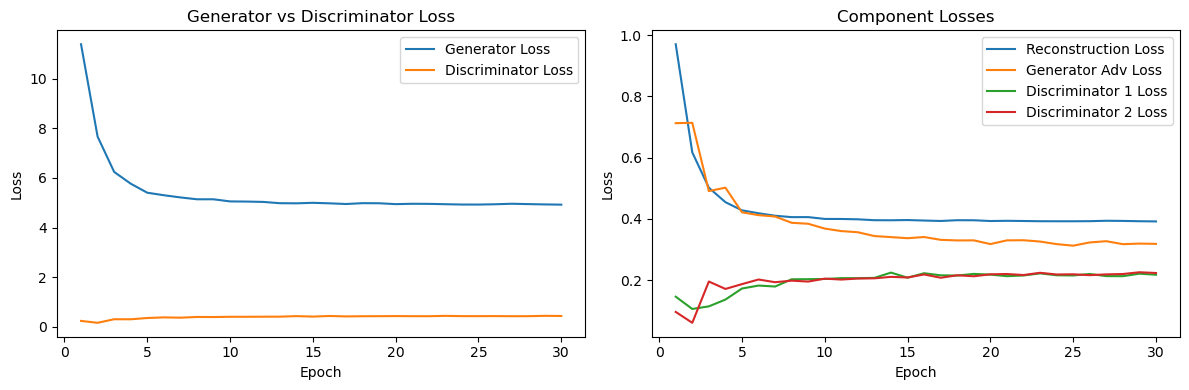

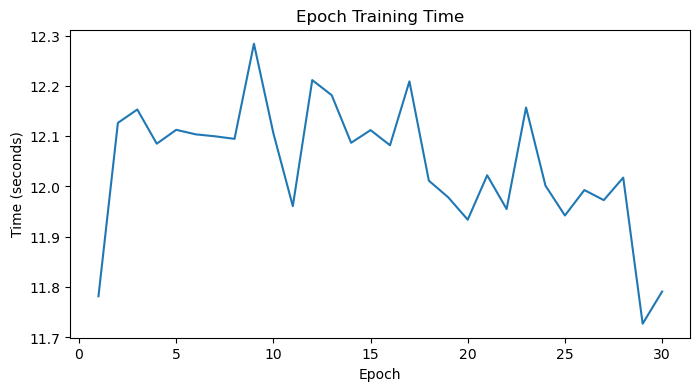

Model saved at epoch 30
Training completed successfully!
Model checkpoints and sample images saved in the working directory.


In [61]:
print("Starting model training...")

# Only run if dataset is available
if DATASET_PATH and os.path.exists(DATASET_PATH):
    try:
        # Create trainer
        trainer = DDcGANTrainer(
            dataset_path=DATASET_PATH,
            batch_size=BATCH_SIZE,
            lr=LEARNING_RATE,
            img_size=IMG_SIZE,
            device=DEVICE
        )
        
        print("Trainer created successfully. Starting training...")
        
        # Start training
        trainer.train(NUM_EPOCHS, save_interval=10)
        
        # Save final model
        trainer.save_model(NUM_EPOCHS, 'final_models')
        
        print("Training completed successfully!")
        print("Model checkpoints and sample images saved in the working directory.")
        
    except Exception as e:
        print(f"Error during training: {e}")
        print("Training failed. Please check the dataset path and format.")
        import traceback
        traceback.print_exc()
else:
    print("Dataset not available. Please ensure the KAIST dataset is properly set up.")
    

Setting up demonstration and testing...
Found checkpoint: final_models/ddcgan_epoch_30.pth
✓ Loaded model from final_models/ddcgan_epoch_30.pth
Scanning dataset directory: Dataset/CT-MRI
Found CT and MRI directories
Found 573 CT images and 573 MRI images
Found 573 valid image pairs


/tmp/ipykernel_9228/2694983952.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=DEVICE)


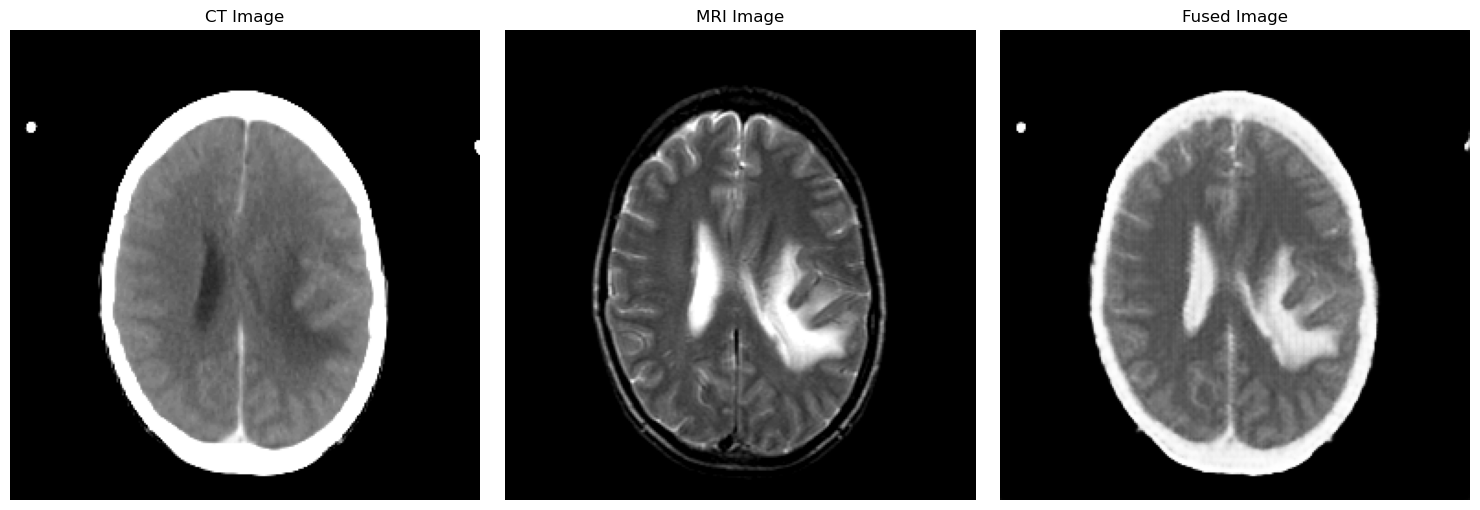

Demonstration completed! Image saved as 'test_demonstration.png'
Demonstration and testing complete!


In [62]:
print("Setting up demonstration and testing...")

def load_test_image_pair():
    """Load a sample CT and MRI image pair for testing"""
    # Create a simple test dataset
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    
    try:
        test_dataset = CTMRIDataset(DATASET_PATH, transform=test_transform, img_size=IMG_SIZE)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
        
        # Get one sample
        for ct_img, mri_img in test_loader:
            return ct_img, mri_img
    except:
        # Create dummy data if dataset is not available
        print("Using dummy data for demonstration")
        dummy_ct = torch.rand(1, 1, IMG_SIZE[0], IMG_SIZE[1]) * 2 - 1
        dummy_mri = torch.rand(1, 1, IMG_SIZE[0], IMG_SIZE[1]) * 2 - 1
        return dummy_ct, dummy_mri

def test_model(checkpoint_path=None):
    """Test the trained model on sample images"""
    # Create a simple generator for demonstration if no checkpoint is available
    generator = Generator(in_channels=2, out_channels=1).to(DEVICE)
    
    if checkpoint_path and os.path.exists(checkpoint_path):
        try:
            # Load checkpoint
            checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
            generator.load_state_dict(checkpoint['generator_state_dict'])
            print(f"✓ Loaded model from {checkpoint_path}")
        except Exception as e:
            print(f"✗ Could not load model: {e}")
            print("Using untrained model for demonstration")
    else:
        print("No checkpoint provided. Using untrained model for demonstration.")
    
    # Set to evaluation mode
    generator.eval()
    
    # Load test images
    ct_img, mri_img = load_test_image_pair()
    ct_img = ct_img.to(DEVICE)
    mri_img = mri_img.to(DEVICE)
    
    # Create input by concatenating CT and MRI images
    input_img = torch.cat([ct_img, mri_img], dim=1)
    
    # Generate fused image
    with torch.no_grad():
        fused_img = generator(input_img)
    
    # Denormalize images for display
    ct_img_display = (ct_img.cpu().squeeze() + 1) / 2
    mri_img_display = (mri_img.cpu().squeeze() + 1) / 2
    fused_img_display = (fused_img.cpu().squeeze() + 1) / 2
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(ct_img_display, cmap='gray')
    axes[0].set_title('CT Image')
    axes[0].axis('off')
    
    axes[1].imshow(mri_img_display, cmap='gray')
    axes[1].set_title('MRI Image')
    axes[1].axis('off')
    
    axes[2].imshow(fused_img_display, cmap='gray')
    axes[2].set_title('Fused Image')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('test_demonstration.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Demonstration completed! Image saved as 'test_demonstration.png'")

# Check for available checkpoints
checkpoint_files = []
if os.path.exists('checkpoints'):
    checkpoint_files = [f for f in os.listdir('checkpoints') if f.endswith('.pth')]
if os.path.exists('final_models'):
    checkpoint_files.extend([f for f in os.listdir('final_models') if f.endswith('.pth')])

if checkpoint_files:
    # Use the latest checkpoint
    checkpoint_files.sort()
    latest_checkpoint = os.path.join('checkpoints' if 'checkpoints' in checkpoint_files[-1] else 'final_models', 
                                    checkpoint_files[-1])
    print(f"Found checkpoint: {latest_checkpoint}")
    test_model(latest_checkpoint)
else:
    print("No checkpoints found. Running demonstration with untrained model.")
    test_model()

print("Demonstration and testing complete!")